## MINST Dataset Experiment with FL


In [1]:
%pip install requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import json
import os
import json
import os



RSA_SIZE = 2048


DEFAULT_CURVE = "secp384r1"
FAST_CURVE = "secp256r1"
SUPPORTED_CURVES = [DEFAULT_CURVE, FAST_CURVE]

DIGEST_SHA384 = "sha384"
DIGEST_SHA256 = "sha256"

RSA_SIZE = 2048
# CCF network node
server="https://127.0.0.1:8000"

num_users = 4
# Getting Network metrices
url = server + "/app/api/metrics"

try:
    response = requests.get(url, verify='./workspace/sandbox_common/service_cert.pem')

    print("Status Code:", response.status_code)
    print("\nResponse Headers:")
    for header, value in response.headers.items():
        print(f"{header}: {value}")

    print("\nResponse Body:")
    try:
        # Attempt to parse JSON and print it in an indented format
        response_json = response.json()
        print(json.dumps(response_json, indent=4))
    except ValueError:
        # If response is not JSON, print as plain text
        print(response.text)

except requests.exceptions.RequestException as e:
    print("Error making request:", e)

Status Code: 200

Response Headers:
content-length: 176
content-type: application/json

Response Body:
{
    "metrics": [
        {
            "calls": 1,
            "errors": 0,
            "failures": 0,
            "method": "GET",
            "path": "api/metrics",
            "retries": 0
        },
        {
            "calls": 2,
            "errors": 0,
            "failures": 0,
            "method": "GET",
            "path": "commit",
            "retries": 0
        }
    ]
}


In [3]:
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL



def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights =deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None


def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []
def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id,round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)
  
    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")
def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=1):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    return history.history['loss']

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')
    

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
      "global_model": {
        "model_name": "CNNModel",
        "model_data": model_base64
      }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None
def flatten_weights(model):
    """Flatten the model weights"""
    flat_weights = []
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:
            flat_weights.append(weights[0].flatten())
    return np.concatenate(flat_weights)
def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights


def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights



def serialize_weights(model):
    weights = model.get_weights()
    serialized_weights = []
    for weight in weights:
        serialized_weights.append(weight.tolist())
    return json.dumps(serialized_weights)



def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
  

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data
            
            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")
        
        time.sleep(2)  # Delay before retrying
        attempts += 1
    
    raise Exception("Failed to download model after maximum retries.")
def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()
def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]
        
        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Conv2D):
                    # Check if it's a Conv2D layer
                    weights_shape = local_layers[i].get_weights()[0].shape
                    provided_weights_shape = global_model_weights[i][0].shape
                    print(f"Layer {local_layers[i].name} - Expected shape: {weights_shape}, Provided shape: {provided_weights_shape}")
                    
                    if weights_shape == provided_weights_shape:
                        local_layers[i].set_weights([global_model_weights[i][0], global_model_weights[i][1]])
                    else:
                        try:
                            reshaped_kernel_weights = np.reshape(global_model_weights[i][0], weights_shape)
                            local_layers[i].set_weights([reshaped_kernel_weights, global_model_weights[i][1]])
                        except ValueError as e:
                            print(f"Error reshaping weights for layer {local_layers[i].name}: {e}")
                elif isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                # Add similar checks for other layer types if needed
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")

2024-05-27 18:06:12.740514: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 18:06:12.812253: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 18:06:12.813976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 18:06:13.845829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading and preprocessing MNIST dataset...
Deleted temporary model file: temp_model.h5
Splitting dataset for two users...
Initializing the global model...
Serializing the model...
Uploading initial global model...
Initial global model 'CNNModel' (ID: 0) uploaded successfully.
Attempting to download model for User 0, Round 0, Attempt 1...


/workspaces/CCF_FL_Block/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training model for User 0, Round 1...
938/938 [==============================] - 22s 23ms/step - loss: 0.5715 - accuracy: 0.9000 - val_loss: 0.1337 - val_accuracy: 0.9610
Uploading model weights for Round 1...
{"message":"Model weights received"}
Model weights uploaded successfully for Round 1.
Training model for User 1, Round 1...
938/938 [==============================] - 21s 22ms/step - loss: 0.1274 - accuracy: 0.9629 - val_loss: 0.1105 - val_accuracy: 0.9692
Uploading model weights for Round 1...
{"message":"Model weights received"}
Model weights uploaded successfully for Round 1.
Aggregating weights for model: 0
Aggregation successful for model: 0
Failed to download global weights. Status code: 404
Training model for User 0, Round 2...
938/938 [==============================] - 21s 22ms/step - loss: 0.0886 - accuracy: 0.9734 - val_loss: 0.0933 - val_accuracy: 0.9739
Uploading model weights for Round 2...
{"message":"Model weights received"}
Model weights uploaded successfully for 

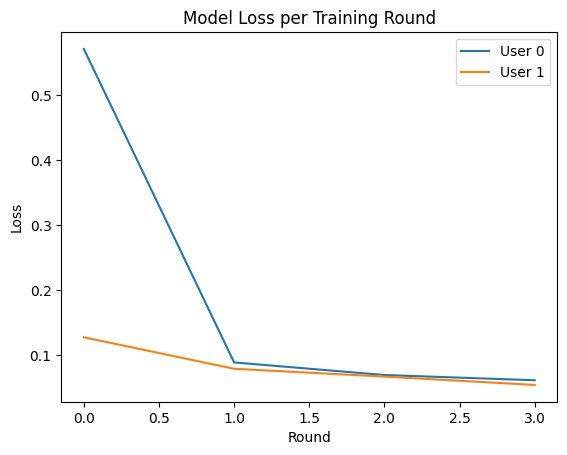

Deleted temporary model file: temp_model.h5


In [4]:
# Load and preprocess MNIST dataset
print("Loading and preprocessing MNIST dataset...")
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()
# Split the dataset for two users
print("Splitting dataset for two users...")
split_index = int(len(X_train) / 2)
X_train_user0, X_train_user1 = np.split(X_train, [split_index])
y_train_user0, y_train_user1 = np.split(y_train, [split_index])

# Initialize and train the global model (User 0)
global_model = create_model()
# train_model(global_model, X_train_user0, y_train_user0, X_test, y_test, user_id=0, round_no=0)


# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem")


if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")
num_rounds = 4  # Number of training rounds
user_losses = {0: [], 1: []}  # To track losses for each user

# Download the latest global model once for each client
global_model = download_model(
    "./workspace/sandbox_common/user0_cert.pem",
    "./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for both users
local_model_user0 = global_model
local_model_user1 = global_model

for round_no in range(1, num_rounds + 1):
    for user_id in range(2):  # Two users: 0 and 1
        # Train the local model on the user's data
        X_train_user = X_train_user0 if user_id == 0 else X_train_user1
        y_train_user = y_train_user0 if user_id == 0 else y_train_user1
        loss = train_model(local_model_user0 if user_id == 0 else local_model_user1,
                           X_train_user, y_train_user, X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_model_user0 if user_id == 0 else local_model_user1)
        

        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id,round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_model_user0
    )

print("Federated Learning Process Completed.")

# Plot loss graphs for each user
plot_loss(user_losses)
delete_temp_model_file()